In [43]:
import glob
import re
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix

%matplotlib inline

In [2]:
data_path = '../../Dataset/jakartaresearch/indonesian-news'

In [5]:
files = glob.glob(data_path + '/*')

In [6]:
files

['../../Dataset/jakartaresearch/indonesian-news/testing.res',
 '../../Dataset/jakartaresearch/indonesian-news/training.res']

In [7]:
train = pickle.load(open(files[1], 'rb'))
test = pickle.load(open(files[0], 'rb'))

In [10]:
d_train = pd.DataFrame({'content': train[0], 'label': train[1]})
d_test = pd.DataFrame({'content': test[0], 'label': test[1]})

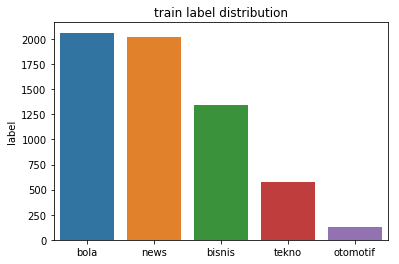

In [39]:
train_plot = sns.barplot(y = d_train.label.value_counts(), x = d_train.label.value_counts().index).set_title('train label distribution')
train_plot.get_figure().savefig('train_dist.png')

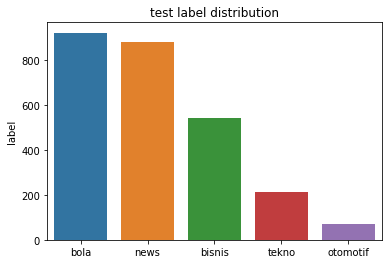

In [40]:
test_plot = sns.barplot(y = d_test.label.value_counts(), x = d_test.label.value_counts().index).set_title('test label distribution')
test_plot.get_figure().savefig('test_dist.png')

## cleansing

In [14]:
def cleansing(text):
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]
    text = ' '.join(word_list)
    
    return text

In [23]:
d_train['content_cleansing'] = d_train.content.apply(cleansing)
d_test['content_cleansing'] = d_test.content.apply(cleansing)

## feature extraction

In [21]:
cv = CountVectorizer()

In [24]:
X_train = cv.fit_transform(d_train.content_cleansing)
X_test = cv.transform(d_test.content_cleansing)

## model

In [26]:
mnb = MultinomialNB()

In [27]:
mnb.fit(X_train, d_train.label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
y_pred = mnb.predict(X_test)

## evaluation

In [31]:
f1_score(d_test.label, y_pred, average='macro')

0.8600383411291406

In [32]:
recall_score(d_test.label, y_pred, average='macro')

0.8336679198085388

In [37]:
precision_score(d_test.label, y_pred, average='macro')

0.9184387842440312

In [51]:
label = list(d_test.label.value_counts().index)

In [54]:
label

['bola', 'news', 'bisnis', 'tekno', 'otomotif']

In [55]:
cm = confusion_matrix(d_test.label, y_pred, labels = label)

In [58]:
pd.DataFrame(data = cm, columns=label, index=label)

,bola,news,bisnis,tekno,otomotif
bola,894,20,3,6,0
news,8,799,71,2,0
bisnis,4,36,493,9,0
tekno,1,10,17,184,0
otomotif,0,9,14,11,36


In [59]:
d_test.label.value_counts()

bola        923
news        880
bisnis      542
tekno       212
otomotif     70
Name: label, dtype: int64